In [78]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from dirty_cat import TargetEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# warnings
import warnings
warnings.filterwarnings('ignore')

# custom functions
from hw3_functions import *

# other
pd.set_option('display.max_columns', 100)
np.random.seed(42)

# HW3 - Payment Classification

By Corentin Llorca (cl3783) and Costas Vafeades (cv2451)

Goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not. All relevant data can be found [here](https://www.cms.gov/OpenPayments/Explore-the-Data/Dataset-Downloads.html).

### Data Description

Physicians may be identified as covered recipients of records or as principal investigators associated with research-related payment records. Teaching hospitals may also be identified as covered recipients. Teaching hospitals are defined as any hospital receiving payments for GM, IPPS or IME. 


Each record in the General Payment, Research Payment, and Ownership/Investment files includes a Change Type indicator field. 
- NEW: the record is newly reported by the reporting entity since the last publication and is being published for the first time.
- ADD: the record is not new in the system but, due to the record not being eligible for publication until the current publication cycle, is being published for the first time.
- CHANGED: record was previously published but has been modified since its last publication. A record whose only change since the last publication is a change to its dispute status is categorized as a changed record.
- UNCHANGED: record was published during the last publication cycle and is being republished without change in the current publication. 

## Task 1: Identify Features

First of all, let's load the data to assemble the dataset. The data comes from two different csv files, OP_DTL_GNRL_PGYR2017_P01182019.csv (general payments) and OP_DTL_RSRCH_PGYR2017_P01182019.csv (research payments), so we load a subsample of those two files, add the target feature "research_payment" (0 for rows in the first file and 1 for rows in the second file) and concatenate them. 

### How do we balance classes? 

The data is naturally imbalanced, as there are much more records of general payments than research payments. Here are the row counts for both files: 

In [4]:
n_gen = sum(1 for line in open('data\OP_DTL_GNRL_PGYR2017_P01182019.csv')) - 1
n_res = sum(1 for line in open('data\OP_DTL_RSRCH_PGYR2017_P01182019.csv')) - 1
# the -1 is to exclude header

print("General payments: " + str(n_gen) + " lines")
    
print("Research payments: " + str(n_res) + " lines")

General payments: 10663833 lines
Research payments: 602530 lines


Since the general payments csv is way too large to load, we will select a subsample of the rows for each csv, forming the whole dataset. We have the choice of how many rows to select in each file, and the choice we make will end up deciding the class balance. Here are the two options we have: 
* Select an equal number of rows for both classes: this completely removes class imbalance and the problems it might cause. However, we lose the "real-world setting" with imbalanced classes

* Select a number of rows in each file that's proportionate to their total number of rows: this will cause class imbalance problems since there is an approximate 95% / 5% class distribution, but will reflect the whole problem better.

We ended up choosing the former. 

### Loading and joining the datasets

We first load the separate datasets and add the target feature. To load the data, we do a random subsampling.

In [5]:
# Number of desired samples for each file
nsamples_gen = 12500
nsamples_res = 12500

skiprows_gen = np.sort(np.random.choice(range(1, n_gen+1), replace = False, size = n_gen - nsamples_res))
skiprows_res = np.sort(np.random.choice(range(1, n_res+1), replace = False, size = n_res - nsamples_res))

gen = pd.read_csv("data\OP_DTL_GNRL_PGYR2017_P01182019.csv", skiprows = skiprows_gen, parse_dates=['Date_of_Payment'])
res = pd.read_csv("data\OP_DTL_RSRCH_PGYR2017_P01182019.csv", skiprows = skiprows_res, parse_dates=['Date_of_Payment'])

gen['research_payment'] = 0
res['research_payment'] = 1

#### Concatenation

The next problem is to concatenate the data. This raises an issue: our two data files have different columns - but also have a lot of columns in common. The "baseline" choice here would be to simply use panda's concatenate function, which would give us a concatenated dataset, whose columns would be the union of the columns of the two separated datasets, filling the missing values with NA. 

However, this creates a problem: since the two separated datasets are also the two separated classes, then if one feature is only non-missing in one of the classes, it might indirectly reveal information about the class to the model, in an unwanted way (data leakage). The solution to that is to only keep the features that are in both datasets when concatenating (inner join instead of outer join).

In [6]:
df = pd.concat([gen, res], join='inner')

### Data Types

We need to check that pandas has loaded the right data types for our dataframe. Printing the dtypes shows us a few irregularities, namely that there are ID features that are counted as floats/ints when they should be used as categoricals. Other than that, there seems to be no problem. We notice, by looking at the dtypes, that the whole dataset has only one continuous variable (Total_Amount_of_Payment_USDollars).

In [7]:
to_cat = ['Teaching_Hospital_CCN', 'Teaching_Hospital_ID',
          'Physician_Profile_ID', 'Physician_License_State_code5',
          'Record_ID', 'Program_Year', 'research_payment']
df = df.astype(dtype={v: object for v in to_cat}, copy=False)

Before proceeding any further, we create a test set for modeling purposes later on. 

In [8]:
df, df_test = df_split(df, 'research_payment')

### Checking for Data Leakage and Irrelevant Features

Before we proceed, it's important to check the values of each of our variables to make sure that they don't leak the target and also remove irrelevant features. 

In [9]:
df.groupby('research_payment').nunique()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,Recipient_Primary_Business_Street_Address_Line1,Recipient_Primary_Business_Street_Address_Line2,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Country,Recipient_Province,Recipient_Postal_Code,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,Physician_License_State_code4,Physician_License_State_code5,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Date_of_Payment,Form_of_Payment_or_Transfer_of_Value,Delay_in_Publication_Indicator,Record_ID,Dispute_Status_for_Publication,Related_Product_Indicator,Covered_or_Noncovered_Indicator_1,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Product_Category_or_Therapeutic_Area_1,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1,Associated_Drug_or_Biological_NDC_1,Covered_or_Noncovered_Indicator_2,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2,Product_Category_or_Therapeutic_Area_2,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2,Associated_Drug_or_Biological_NDC_2,Covered_or_Noncovered_Indicator_3,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3,Product_Category_or_Therapeutic_Area_3,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3,Associated_Drug_or_Biological_NDC_3,Covered_or_Noncovered_Indicator_4,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Payment_Publication_Date,research_payment
research_payment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,2,31,31,30,9969,3368,1019,7059,19,8854,1500,2957,52,7140,1,0,0,6,169,52,43,25,7,1,434,474,474,35,11,4062,350,3,1,10000,1,2,2,4,519,1279,533,2,4,155,338,198,2,3,98,182,111,1,4,43,63,38,2,4,17,22,11,1,1,1
1,3,4,1593,1594,364,407,251,88,348,5,5431,1177,1654,52,2862,4,2,4,5,74,40,3,0,0,0,236,274,277,31,17,5876,316,2,1,10000,2,2,2,3,280,694,367,2,3,25,40,18,1,3,13,18,8,1,4,8,9,3,1,3,7,8,2,1,1,1


We can remove Record_ID as that's a unique identifier of each observation.

In [10]:
cols_drop = ['Record_ID']

Variables that have the same unique value for both research and non-research payments can be considered as irrelevant and be dropped.

In [11]:
for v in df.columns.values[:-1]:
    if len(df[v].unique()) == 1:
        cols_drop.append(v)

df.drop(cols_drop, axis=1, inplace=True)
df_test.drop(cols_drop, axis=1, inplace=True)

Variables that have only one value for either of the two types of payments should be investigated further. 

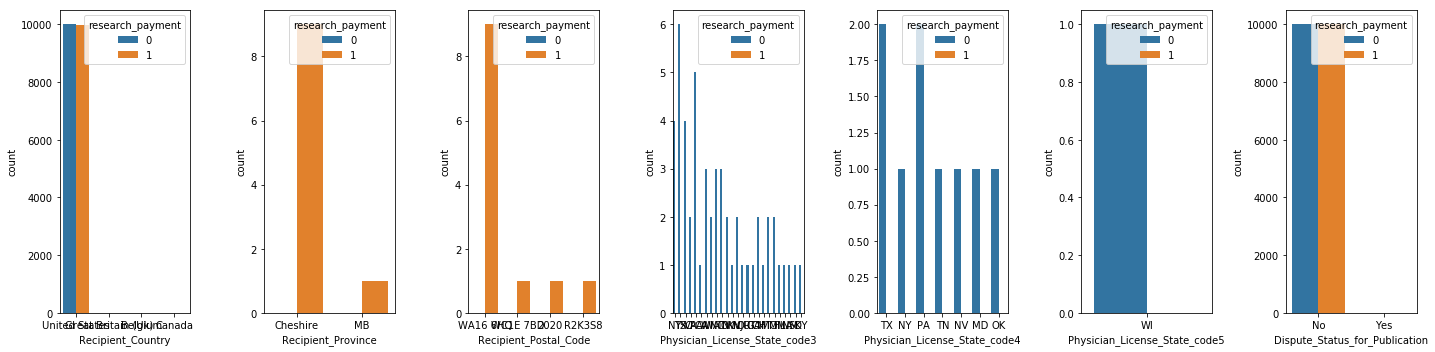

In [12]:
cols_drop = []
for v in df.columns.values[:-1]:
    for i in range(2):
        if len(df[df['research_payment'] == i][v].unique()) == 1:
            if v not in cols_drop: cols_drop.append(v)

                
fig, ax = plt.subplots(1, len(cols_drop), figsize = (20, 5))
i=0
for v in cols_drop:
    sns.countplot(v, hue='research_payment', data = df, ax = ax[i])
    i+=1

plt.tight_layout()

In [13]:
df.drop(cols_drop, axis=1, inplace=True)
df_test.drop(cols_drop, axis=1, inplace=True)

#### Sparse Variables

A big portion of our features don't have any data for one of the targets. 

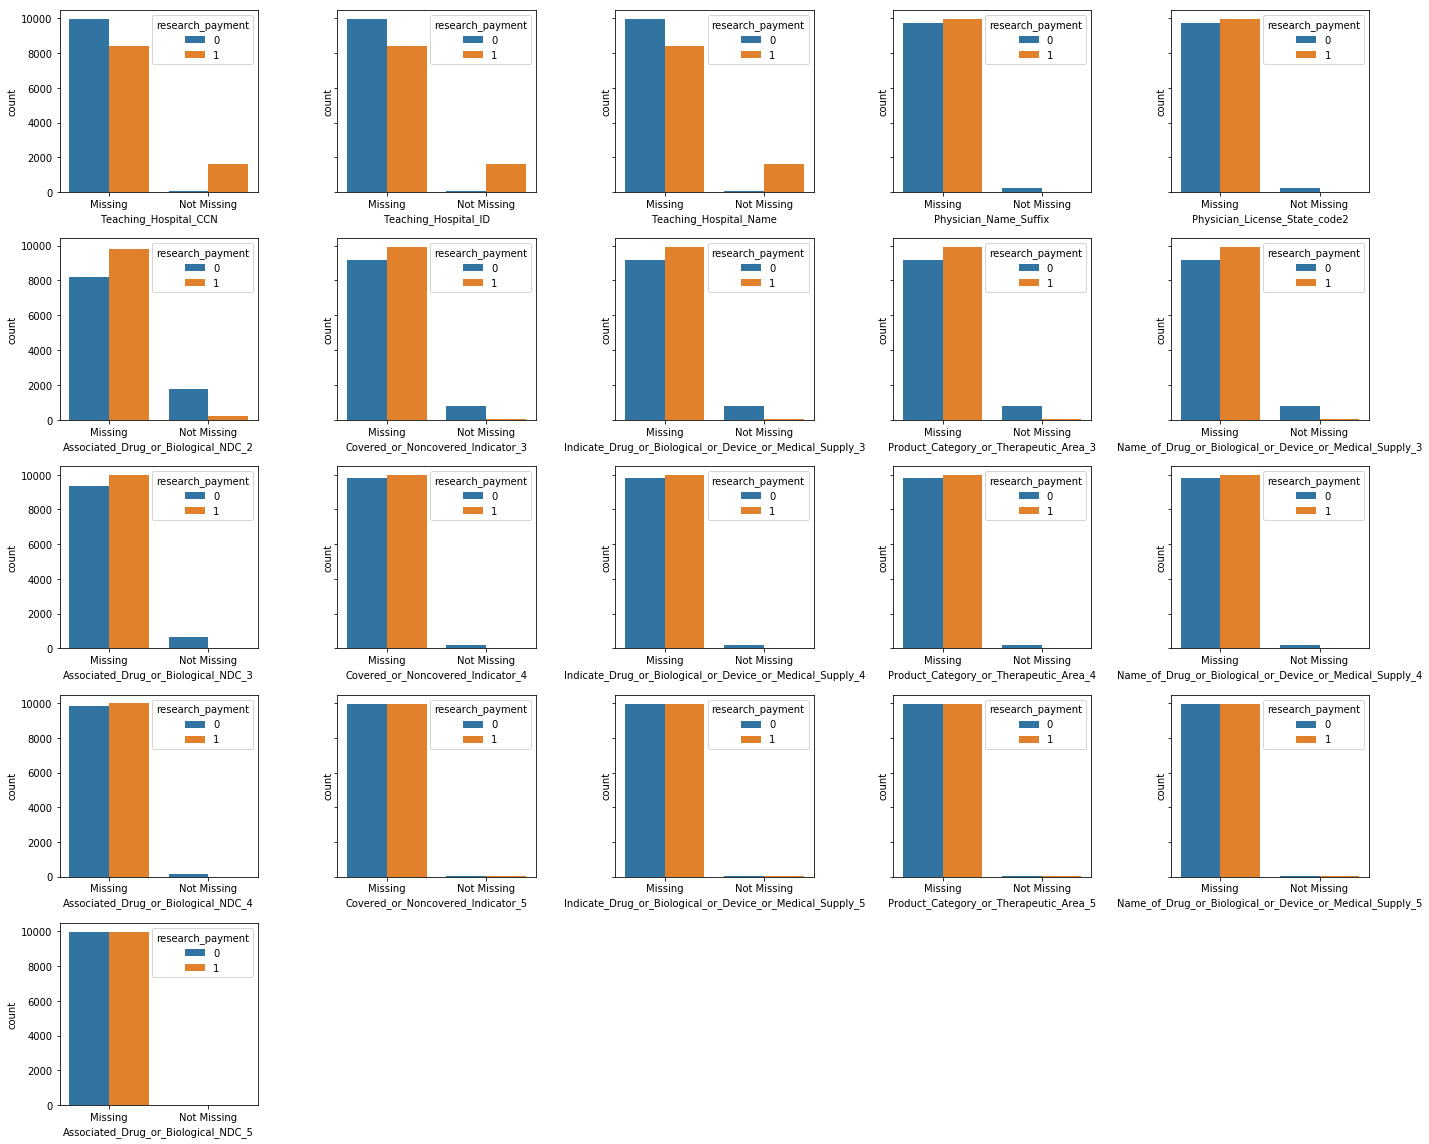

In [14]:
df_missing = df.copy()
for c in df_missing.columns[:-1]:
    df_missing[c] = np.where(df_missing[c].isnull(), 'Missing', 'Not Missing')

fig, ax = plt.subplots(5, 5, figsize = (20, 16), sharey='row')
cols_drop = []
# axis indicators
i = 0
j = 0

for v in df_missing.columns.values[:-1]:
    if df_missing[df_missing[v] == 'Missing'].shape[0] > (df_missing.shape[0] * 0.9):
        sns.countplot(v, hue='research_payment', data = df_missing, ax=ax[j, i])
        cols_drop.append(v)
        # increment axis
        i += 1
        if i == 5: j += 1; i = 0
        
        
fig.delaxes(ax[4, 1])
fig.delaxes(ax[4, 2])
fig.delaxes(ax[4, 3])
fig.delaxes(ax[4, 4])
plt.tight_layout()
plt.show()

In [15]:
cols_drop.remove('Teaching_Hospital_ID')
df.drop(cols_drop, axis=1, inplace=True)
df_test.drop(cols_drop, axis=1, inplace=True)

####  Leaky Variables

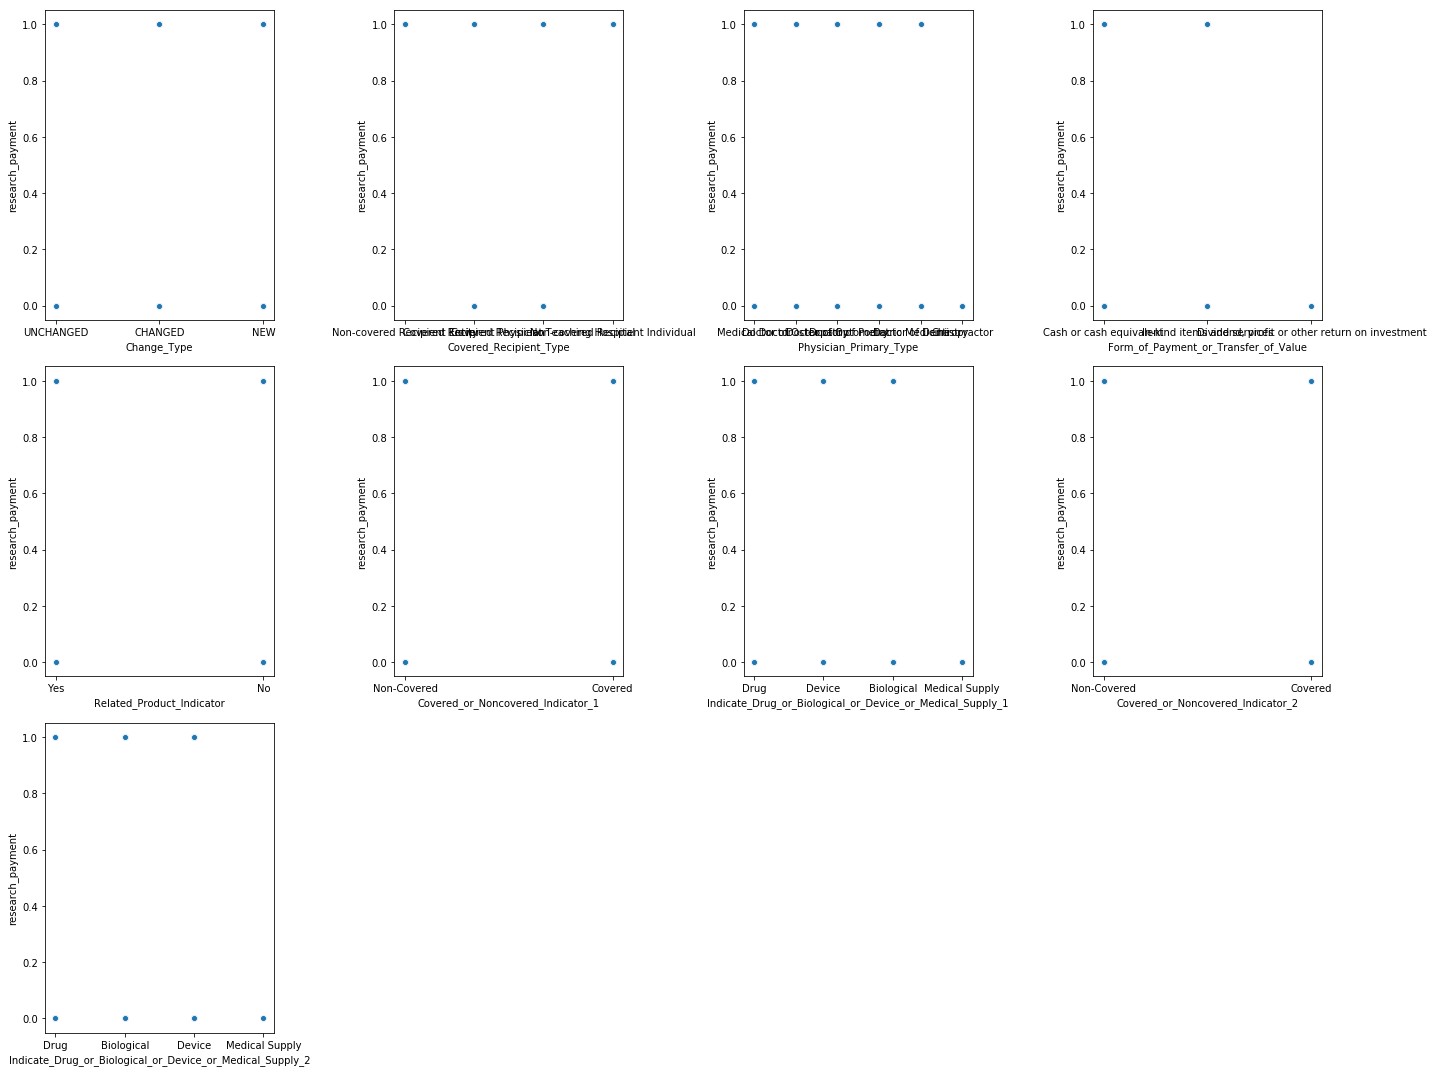

In [16]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
i = 0
j = 0

for c in df.columns.values[:-1]:
    if (len(df[c].unique()) <= 10) | (df[c].dtype != object):
        sns.scatterplot(x=c, y='research_payment', data=df, ax=ax[j, i])
        
        i+=1
        if i == 4: j+=1; i=0
        
        
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])
fig.delaxes(ax[2,3])
plt.tight_layout()
plt.show()

Judging by the plots above, the variables Covered_Recipient_Type, Physician_Primary_Type and Form_of_Payment_or_Transfer_of_Value could be leaking the target. It's important to investigate these further before proceeding.

**Covered_Recipient_Type**

In [17]:
df.groupby(['research_payment', 'Covered_Recipient_Type']).size().reset_index()

,research_payment,Covered_Recipient_Type,0
0,0,Covered Recipient Physician,9969
1,0,Covered Recipient Teaching Hospital,31
2,1,Covered Recipient Physician,407
3,1,Covered Recipient Teaching Hospital,1597
4,1,Non-covered Recipient Entity,7983
5,1,Non-covered Recipient Individual,13


Given that the proportions are very different for each of our targets, this raises further suspicions. General payments are only made to covered recipients so we can remove this variable as it's better to be safe than sorry. 

In [18]:
df.drop('Covered_Recipient_Type', axis=1, inplace=True)
df_test.drop('Covered_Recipient_Type', axis=1, inplace=True)

**Physician_Primary_Type**

In [19]:
df.groupby(['research_payment', 'Physician_Primary_Type']).size().reset_index()

,research_payment,Physician_Primary_Type,0
0,0,Chiropractor,3
1,0,Doctor of Dentistry,269
2,0,Doctor of Optometry,206
3,0,Doctor of Osteopathy,889
4,0,Doctor of Podiatric Medicine,106
5,0,Medical Doctor,8496
6,1,Doctor of Dentistry,4
7,1,Doctor of Optometry,6
8,1,Doctor of Osteopathy,14
9,1,Doctor of Podiatric Medicine,3


The proportions here also raise an eye, but the values don't seem to give away the target.

**Form_of_Payment_or_Transfer_of_Value**

In [20]:
df.groupby(['research_payment', 'Form_of_Payment_or_Transfer_of_Value']).size().reset_index()

,research_payment,Form_of_Payment_or_Transfer_of_Value,0
0,0,Cash or cash equivalent,1555
1,0,"Dividend, profit or other return on investment",1
2,0,In-kind items and services,8444
3,1,Cash or cash equivalent,7865
4,1,In-kind items and services,2135


Again, the proportions are very different for each payment type but it doesn't seem to be a dead giveaway. 

#### Irrelevant Variables

After a quick scan of the remaining variables, we can remove those that don't or at least shouldn't have anything to do with the target. 

In [21]:
cols_drop = ['Physician_First_Name', 'Physician_Middle_Name', 'Recipient_Primary_Business_Street_Address_Line2']
df.drop(cols_drop, axis=1, inplace=True)
df_test.drop(cols_drop, axis=1, inplace=True)

#### Renaming our Variables

In [22]:
df = df_rename(df)
df_test = df_rename(df_test)

## Task 2: Preprocessing and baseline model

For the simple minimum viable model, we've decided to do logistic regression with a very limited number of features. The filter we've applied to features is the following (those are very "harsh" filters but again, this is a baseline model).
* Drop all features with more than 10% missing data (considered "sparse")
* Drop all categorical features with too many categories since we're going to one-hot encode them. We've chosen 200 (1% of the number of data points) as a threshold

In [23]:
cols_drop2 = list(df.columns[df.isnull().sum() > 0.1*df.shape[0]])
cats = df.columns[df.dtypes == object]
cols_drop2.extend(cats[df[cats].nunique() > 0.01*df.shape[0]])
df2 = df.drop(set(cols_drop2), axis=1)
df2_test = df_test.drop(set(cols_drop2), axis=1)
df2.columns

Index(['Change_Type', 'state', 'paying_GPO_state', 'paying_GPO_country',
       'payment_form', 'Related_Product_Indicator', 'product1_covered',
       'research_payment'],
      dtype='object')

As we can see, we're left with only a few features, only one of which is continuous. We can now set up a baseline model, with basic preprocessing: we're only going to one-hot encode the categorical variables.

We assign the "missing" category to missing values in categorical variables (such treatment normally shouldn't be done on X directly, but here it doesn't imply data leakage so it's OK). No treatment is needed for the continuous variable since it has no missing value. We then split training and test set.

We also need to change y to -1 and 1.

In [24]:
X = df2.drop('research_payment', axis=1)
y = df2['research_payment']

X_test = df2_test.drop('research_payment', axis=1)
y_test = df2_test['research_payment']

X_cats = X.columns[X.dtypes == object].tolist()
dict_missing = {i: 'Missing' for i in X_cats}
X.fillna(dict_missing, inplace=True)
X_test.fillna(dict_missing, inplace=True)

y = y.astype(int)*2 - 1
y_test = y_test.astype(int)*2 - 1

In [25]:
ohe = OneHotEncoder(categories="auto", handle_unknown = 'ignore')
logr = LogisticRegression()
prep = ColumnTransformer([("one-hot encoding", ohe, X_cats)])
pipe = Pipeline([('preprocessing', prep), ('logreg', logr)])
np.mean(cross_val_score(pipe, X, y, cv=10, scoring='roc_auc'))

0.9286071499999998

In [26]:
pipe.fit(X, y)
pipe.score(X_test, y_test)

0.8738

## Task 3: Feature Engineering

Building on a lot of the feature analysis done above, we can engineer our variables with a finer detail to enhance our model performance. 

In [27]:
for v in ['phy_ID', 'paying_GPO_ID', 'payment_amount', 'research_payment']:
    df[v] = pd.to_numeric(df[v])
    df_test[v] = pd.to_numeric(df_test[v])

df['payment_date'] = pd.to_datetime(df.payment_date)
df_test['payment_date'] = pd.to_datetime(df_test.payment_date)

In [28]:
df.head(2)

,Change_Type,hospital,phy_ID,phy_last_name,address,city,state,zip_code,phy_primary_type,phy_specialty,phy_state,submitting_GPO_name,paying_GPO_ID,paying_GPO_name,paying_GPO_state,paying_GPO_country,payment_amount,payment_date,payment_form,Related_Product_Indicator,product1_covered,product1_type,product1_category,product1_name,product1_associated,product2_covered,product2_type,product2_category,product2_name,research_payment
0,UNCHANGED,NaN,NaN,NaN,22030 Sherman Way Ste 101,Canoga Park,CA,91303,NaN,NaN,NaN,Sanofi and Genzyme US Companies,100000000067,SANOFI US SERVICES INC.,NJ,United States,350.00,2017-03-14,Cash or cash equivalent,Yes,Non-Covered,Drug,NaN,NO PRODUCT DISCUSSED,NaN,NaN,NaN,NaN,NaN,1
1,UNCHANGED,NaN,206410.0,GARBADAWALA,465 Home Rd N,Ontario,OH,44906,Medical Doctor,Allopathic & Osteopathic Physicians|Internal M...,OH,"Boehringer Ingelheim Pharmaceuticals, Inc.",100000000234,"Boehringer Ingelheim Pharmaceuticals, Inc.",CT,United States,4.33,2017-07-18,In-kind items and services,Yes,Covered,Drug,RESPIRATORY,SPIRIVA,00597-0075-0,NaN,NaN,NaN,NaN,0


Although the values of a lot of our variables provide little insight, the fact that they're non empty may be more useful.

**Hospital, physician ID and last name, Zip-Code**

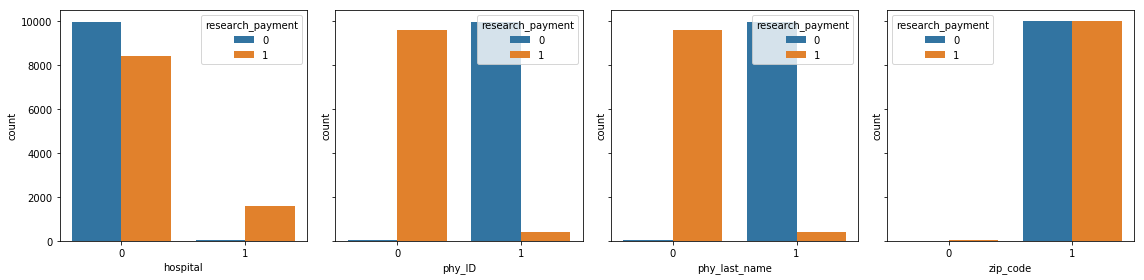

In [29]:
cols_simplify = ['hospital', 'phy_ID', 'phy_last_name', 'zip_code']
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey='row')
i = 0

for c in cols_simplify:
    sns.countplot(np.where(df[c].notnull(), 1, 0), hue=df['research_payment'], ax=ax[i])
    ax[i].set_xlabel(c)
    i+=1
plt.tight_layout()

We can encode these variables to simplify them whilst also preserving any valuable information. Both physician ID and physician last name seem to be leaking the target so we should remove them. Zip-code has a unique value for almost all observations so it's safe to drop it. 

In [30]:
# hospital
df['hospital'] = np.where(df.hospital.notnull(), 1, 0)
df_test['hospital'] = np.where(df_test.hospital.notnull(), 1, 0)

# phy_ID
df['phy_ID'] = np.where(df.phy_ID.notnull(), 1, 0)
df_test['phy_ID'] = np.where(df_test.phy_ID.notnull(), 1, 0)

# drop last name, zip code and phy ID
df.drop(['phy_last_name', 'zip_code', 'phy_ID'], axis=1, inplace=True)
df_test.drop(['phy_last_name', 'zip_code', 'phy_ID'], axis=1, inplace=True)

For the remaining text variables, it might be a good idea to set all their values to lower case before proceeding in case there are any duplicates that have been skipped. 

In [31]:
for c in df.columns.values[:-1]:
    if df[c].dtype == object:
        df[c] = df[c].str.lower()
        df_test[c] = df_test[c].str.lower()

**Address**

Almost every observation has a different address, so on first glance this might not be a very useful variable.

In [32]:
df.groupby(['research_payment', 'address']).size().reset_index().iloc[np.r_[0:2, -2:0]]

,research_payment,address,0
0,0,1 andrew ct,1
1,0,1 associate dr,1
13565,1,west texas retina consultant,1
13566,1,wls fargo lockbox duke university accounts rec...,1


It might be worth extracting the notable parts of each address line by looking for some keywords, e.g university, laboratory, medical, hospital etc. 

We'll map all address to either a hospital/lab/uni or other. 

In [33]:
# university
df['address'] = np.where(df.address.str.contains('uni|depart|medic|lab|resear|foundat', regex=True), 'university', df.address)
df_test['address'] = np.where(df_test.address.str.contains('uni|depart|medic|lab|resear|foundat', regex=True), 'university', df_test.address)
# hospital
df['address'] = np.where(df.address.str.contains('hosp|clinic', regex=True), 'hospital', df.address)
df_test['address'] = np.where(df_test.address.str.contains('hosp|clinic', regex=True), 'hospital', df_test.address)
# po box
df['address'] = np.where(df.address.str.contains('box', regex=True), 'pobox', df.address)
df_test['address'] = np.where(df_test.address.str.contains('box', regex=True), 'pobox', df_test.address)
# other
df['address'] = np.where(df.address.str.contains('hosp|lab|uni|box', regex=True), df.address, 'other')
df_test['address'] = np.where(df_test.address.str.contains('hosp|lab|uni|box', regex=True), df_test.address, 'other')

In [34]:
df.groupby(['research_payment', 'address']).size().reset_index()

,research_payment,address,0
0,0,hospital,105
1,0,other,9469
2,0,pobox,102
3,0,university,324
4,1,hospital,86
5,1,other,9087
6,1,pobox,296
7,1,university,531


**City**

In [35]:
print('The city variable has {} unique values.'.format(len(df.city.unique())))

The city variable has 2574 unique values.


In [36]:
df.groupby(['research_payment', 'city']).size().reset_index()[df.groupby(['research_payment', 'city']).size().reset_index()[0] >= 100]

,research_payment,city,0
939,0,houston,150
1422,0,new york,151
2365,1,atlanta,131
2423,1,boston,212
2497,1,chicago,148
2516,1,columbus,100
2545,1,dallas,255
2755,1,houston,193
2880,1,los angeles,163
2939,1,miami,122


It might be beneficial for us to keep the most popular cities and group all the others in a common category as the sparsity certainly doesn't help our model. 

In [37]:
popular_cities = df.groupby(['research_payment', 'city']).size().reset_index()[df.groupby(['research_payment', 'city']).size().reset_index()[0] >= 100]['city'].unique()
# remap the city variable
df['city'] = np.where(np.isin(df.city, popular_cities), df.city, 'other')
df_test['city'] = np.where(np.isin(df_test.city, popular_cities), df_test.city, 'other')

In [38]:
print('The variable city now has {} unique values.'.format(len(df.city.unique())))

The variable city now has 14 unique values.


**State**

In [39]:
print('The variable State has {} unique values.'.format(len(df.state.unique())))

The variable State has 53 unique values.


Although not as sparse as the previous variable, this might also be problematic. We can try to visualize the proportions in case it helps. 

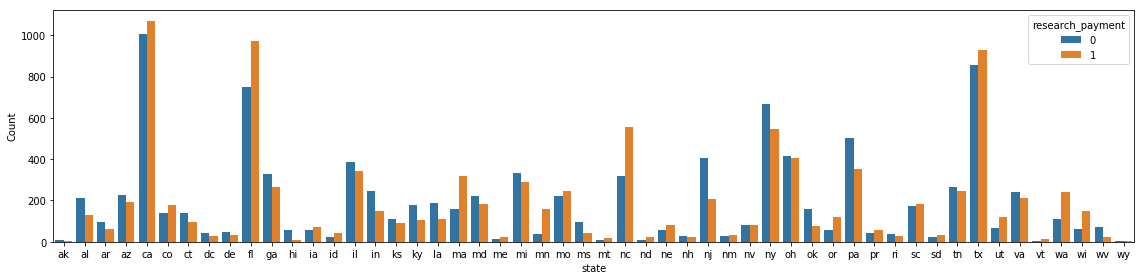

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(x='state', y=0, hue='research_payment', data=df.groupby(['research_payment', 'state']).size().reset_index(), ax = ax)
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

We could try Mean Encoding that may deal with the sparsity appropriately.

In [41]:
df['state'].fillna('missing', inplace=True)
df['state_enc'] = TargetEncoder(clf_type='binary-clf', handle_unknown='ignore').fit_transform(df.state.values.reshape(-1, 1), df.research_payment.values)

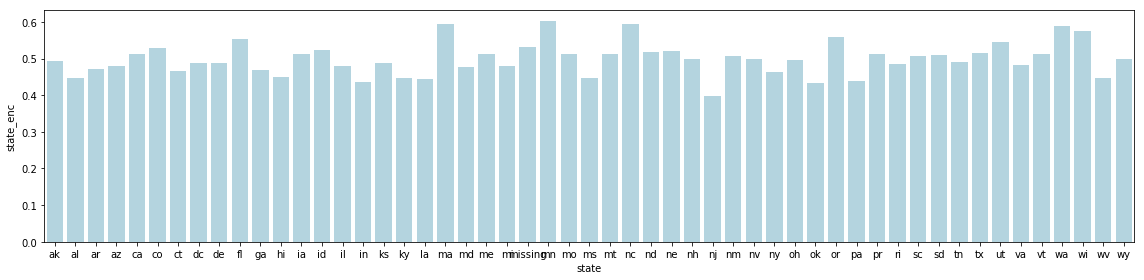

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
sns.barplot(x='state', y='state_enc', data=df.groupby('state')['state_enc'].first().reset_index(), ax=ax, color='lightblue')
df.drop('state_enc', axis=1, inplace=True)
plt.tight_layout()
plt.show()

**Physician Primary Type**

In [43]:
df.groupby(['research_payment', 'phy_primary_type']).size().reset_index()

,research_payment,phy_primary_type,0
0,0,chiropractor,3
1,0,doctor of dentistry,269
2,0,doctor of optometry,206
3,0,doctor of osteopathy,889
4,0,doctor of podiatric medicine,106
5,0,medical doctor,8496
6,1,doctor of dentistry,4
7,1,doctor of optometry,6
8,1,doctor of osteopathy,14
9,1,doctor of podiatric medicine,3


It seems that the majority of general payments are made to medical doctors where as the majority of primary types are null for research payments.

In [44]:
df['doctor'] = np.where(df.phy_primary_type.isnull(), 0, 1)
df_test['doctor'] = np.where(df_test.phy_primary_type.isnull(), 0, 1)
# drop the original
df.drop('phy_primary_type', axis=1, inplace=True)
df_test.drop('phy_primary_type', axis=1, inplace=True)

**Physician Specialty**

In [45]:
df.groupby(['research_payment', 'phy_specialty']).size().reset_index().iloc[np.r_[0:2, -2:0]]

,research_payment,phy_specialty,0
0,0,allopathic & osteopathic physicians|allergy & ...,77
1,0,allopathic & osteopathic physicians|allergy & ...,21
241,1,podiatric medicine & surgery service providers...,1
242,1,"student, health care|student in an organized h...",2


It seems that this feature requires some further parsing.

In [46]:
df['phy_specialty'] = df['phy_specialty'].str.split('|').str[0]
df_test['phy_specialty'] = df_test['phy_specialty'].str.split('|').str[0]

In [47]:
df.groupby(['research_payment', 'phy_specialty']).size().reset_index()

,research_payment,phy_specialty,0
0,0,allopathic & osteopathic physicians,9195
1,0,ambulatory health care facilities,1
2,0,behavioral health & social service providers,2
3,0,chiropractic providers,3
4,0,dental providers,262
5,0,eye and vision services providers,206
6,0,other service providers,125
7,0,podiatric medicine & surgery service providers,112
8,0,"student, health care",45
9,0,"technologists, technicians & other technical s...",1


Judging by the proportions here, it seems that the majority of general payments are made to allopathic and osteopathic physicians. The majority of phy_specialty for research payments is actually null. This might be indicative of a data leak.

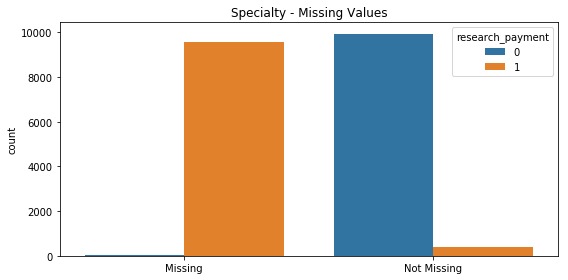

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(np.where(df.phy_specialty.isnull(), 0, 1), hue=df['research_payment'])
ax.set_title('Specialty - Missing Values')
plt.xticks([0,1], labels=['Missing', 'Not Missing'])
plt.tight_layout()
plt.show()

Following the same reasoning as before, we should remove this variable as it's looking very likely that it's leaking the target.

In [49]:
df.drop('phy_specialty', axis=1, inplace=True)
df_test.drop('phy_specialty', axis=1, inplace=True)

**GPO Names**

submitting_GPO_name and paying_GPO_name are very often the same; are the observations where the two are different indicative of anything? 

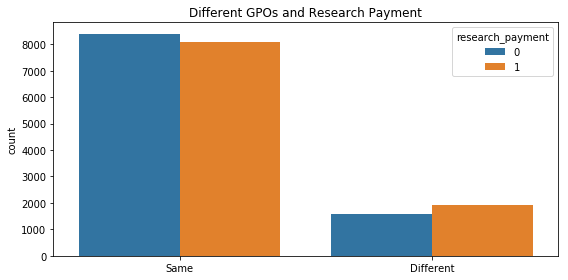

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(np.where(df.submitting_GPO_name != df.paying_GPO_name, 1, 0), hue=df['research_payment'])
ax.set_title('Different GPOs and Research Payment')
plt.xticks([0,1], labels=['Same', 'Different'])
plt.tight_layout()
plt.show()

It seems that the majority of payments have the same submitting and paying GPO; it also looks that the proportions are somewhat different for the two. 

In [51]:
df['different_GPO'] = np.where(df.submitting_GPO_name != df.paying_GPO_name, 1, 0)
df_test['different_GPO'] = np.where(df_test.submitting_GPO_name != df_test.paying_GPO_name, 1, 0)

# drop the original variables
df.drop(['submitting_GPO_name', 'paying_GPO_name', 'paying_GPO_ID'], axis=1, inplace=True)
df_test.drop(['submitting_GPO_name', 'paying_GPO_name', 'paying_GPO_ID'], axis=1, inplace=True)

**Paying GPO State and Country**

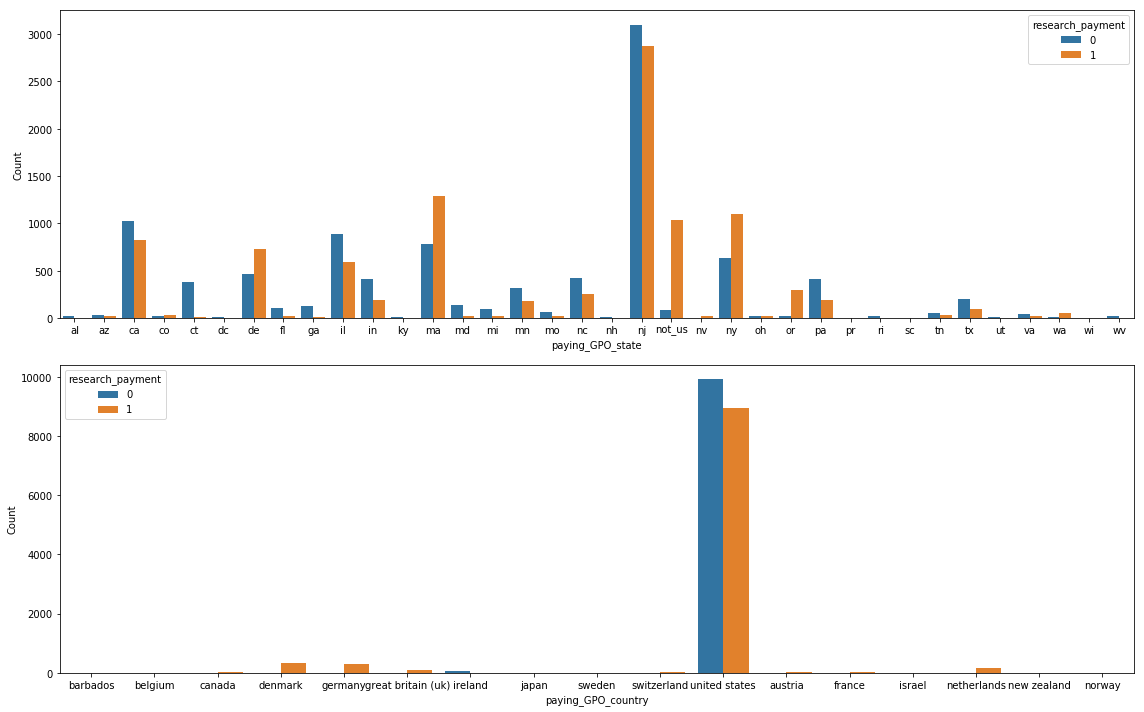

In [52]:
df.paying_GPO_state.fillna('not_us', inplace=True)
df_test.paying_GPO_state.fillna('not_us', inplace=True)

fig, ax = plt.subplots(2, 1, figsize=(16, 10))
sns.barplot(x='paying_GPO_state', y=0, hue='research_payment', data=df.groupby(['research_payment', 'paying_GPO_state']).size().reset_index(), ax = ax[0])
ax[0].set_ylabel('Count')
sns.barplot(x='paying_GPO_country', y=0, hue='research_payment', data=df.groupby(['research_payment', 'paying_GPO_country']).size().reset_index(), ax = ax[1])
ax[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [53]:
df.drop('paying_GPO_country', axis=1, inplace=True)
df_test.drop('paying_GPO_country', axis=1, inplace=True)

By incorporating the information provided in paying_GPO_country in paying_GPO_state, we can drop the country variable. We can now treat the paying GPO state variable the same way we did the original state variable, target encoding. 

**Physician State**

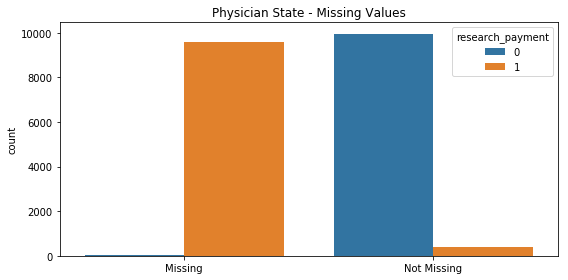

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(np.where(df.phy_state.isnull(), 0, 1), hue=df['research_payment'])
ax.set_title('Physician State - Missing Values')
plt.xticks([0,1], labels=['Missing', 'Not Missing'])
plt.tight_layout()
plt.show()

This is also evidently leaking the target, it might be safer to drop it.

In [55]:
df.drop('phy_state', axis=1, inplace=True)
df_test.drop('phy_state', axis=1, inplace=True)

**Payment Amount**

Our only continuous variable, it's important to see whether it needs scaling or any other transformation. 

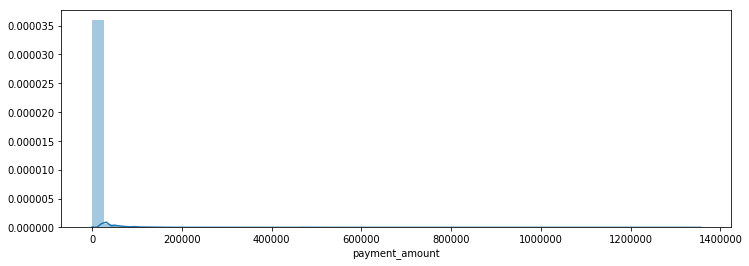

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.distplot(df.payment_amount, ax=ax)
plt.show()

A log transformation might fix the skewness. 

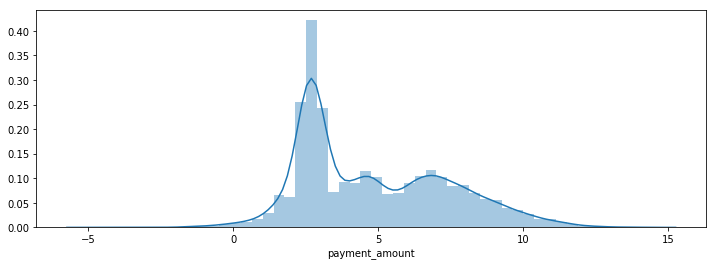

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.distplot(np.log(df.payment_amount), ax=ax)
plt.show()

Although the transformation doesn't take care of the skewness completely, as there still seems to be a positive skewness in our data, we can still proceed. 

In [58]:
df['log_payment_amount'] = np.log(df.payment_amount)
df_test['log_payment_amount'] = np.log(df_test.payment_amount)
df.drop('payment_amount', axis=1, inplace=True)
df_test.drop('payment_amount', axis=1, inplace=True)

**Payment Form**

In [59]:
df.groupby(['research_payment', 'payment_form']).size().reset_index()

,research_payment,payment_form,0
0,0,cash or cash equivalent,1555
1,0,"dividend, profit or other return on investment",1
2,0,in-kind items and services,8444
3,1,cash or cash equivalent,7865
4,1,in-kind items and services,2135


In [60]:
df['cash_payment'] = np.where(df.payment_form == 'cash or cash equivalent', 1, 0)
df_test['cash_payment'] = np.where(df_test.payment_form == 'cash or cash equivalent', 1, 0)

# drop the original
df.drop('payment_form', axis=1, inplace=True)
df_test.drop('payment_form', axis=1, inplace=True)

**Related Product Indicator**

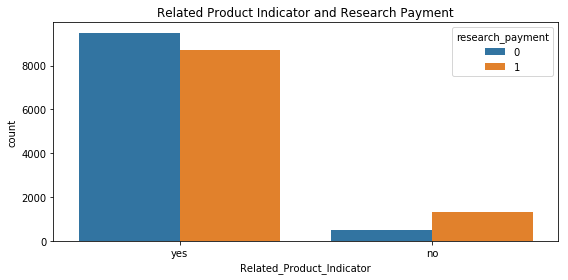

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(df.Related_Product_Indicator, hue=df['research_payment'])
ax.set_title('Related Product Indicator and Research Payment')
plt.tight_layout()
plt.show()

In [62]:
df['related_prod'] = np.where(df.Related_Product_Indicator == 'yes', 1, 0)
df_test['related_prod'] = np.where(df_test.Related_Product_Indicator == 'yes', 1, 0)

# drop the original
df.drop('Related_Product_Indicator', axis=1, inplace=True)
df_test.drop('Related_Product_Indicator', axis=1, inplace=True)

**Product 1 Variables**

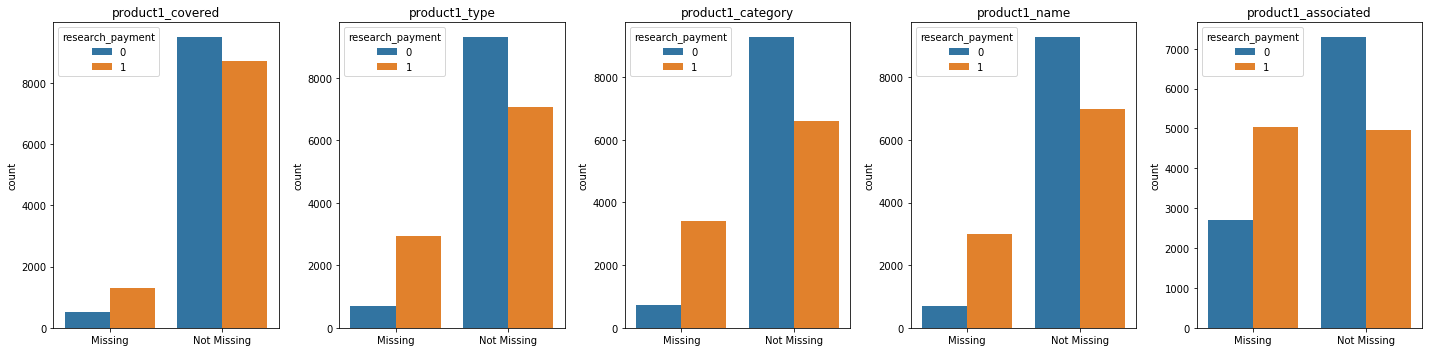

In [63]:
p1_vars = ['product1_covered', 'product1_type', 'product1_category', 'product1_name', 'product1_associated']
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(len(p1_vars)):
    sns.countplot(np.where(df[p1_vars[i]].isnull(), 0, 1), hue=df['research_payment'], ax=ax[i])
    ax[i].set_title(p1_vars[i])
    ax[i].set_xticklabels(['Missing', 'Not Missing'])
    
plt.tight_layout()
plt.show()

In [64]:
df.product1_covered.fillna('missing', inplace=True)
df_test.product1_covered.fillna('missing', inplace=True)
df.groupby(['research_payment', 'product1_covered']).size().reset_index()

,research_payment,product1_covered,0
0,0,covered,9254
1,0,missing,504
2,0,non-covered,242
3,1,covered,6348
4,1,missing,1304
5,1,non-covered,2348


In [65]:
df.product1_type.fillna('missing', inplace=True)
df_test.product1_type.fillna('missing', inplace=True)
df.groupby(['research_payment', 'product1_type']).size().reset_index()

,research_payment,product1_type,0
0,0,biological,1032
1,0,device,1893
2,0,drug,6378
3,0,medical supply,9
4,0,missing,688
5,1,biological,1485
6,1,device,1105
7,1,drug,4469
8,1,missing,2941


In [66]:
df.product1_type.fillna('missing', inplace=True)
df_test.product1_type.fillna('missing', inplace=True)
df.groupby(['research_payment', 'product1_category']).size().reset_index().iloc[np.r_[0:2, -2:0]]

,research_payment,product1_category,0
0,0,1,4
1,0,ablation,1
725,1,wound care,1
726,1,x-ray,1


This feature also requires further parsing.

In [67]:
df['product1_category'] = df['product1_category'].str.split(' ').str[0]
df_test['product1_category'] = df_test['product1_category'].str.split(' ').str[0]

We keep the most popular categories and group the rest as 'other'. 

In [68]:
p1_cats = df.groupby(['research_payment', 'product1_category']).size().reset_index()[df.groupby(['research_payment', 'product1_category']).size().reset_index()[0] > 200]['product1_category'].unique()

# remap p1 category
df['product1_category'] = np.where(np.isin(df.product1_category, p1_cats), df.product1_category, 'other')
df_test['product1_category'] = np.where(np.isin(df_test.product1_category, p1_cats), df_test.product1_category, 'other')

In [69]:
df.product1_name.fillna('missing', inplace=True)
df_test.product1_name.fillna('missing', inplace=True)

df.groupby(['research_payment', 'product1_name']).size().reset_index().iloc[np.r_[0:2, -2:0]]

,research_payment,product1_name,0
0,0,(810) chenodal,1
1,0,(815) thiola,2
1953,1,zykadia,5
1954,1,zytiga,5


In [70]:
df.drop(['product1_name', 'product1_associated'], axis=1, inplace=True)
df_test.drop(['product1_name', 'product1_associated'], axis=1, inplace=True)

**Product 2 Variables**

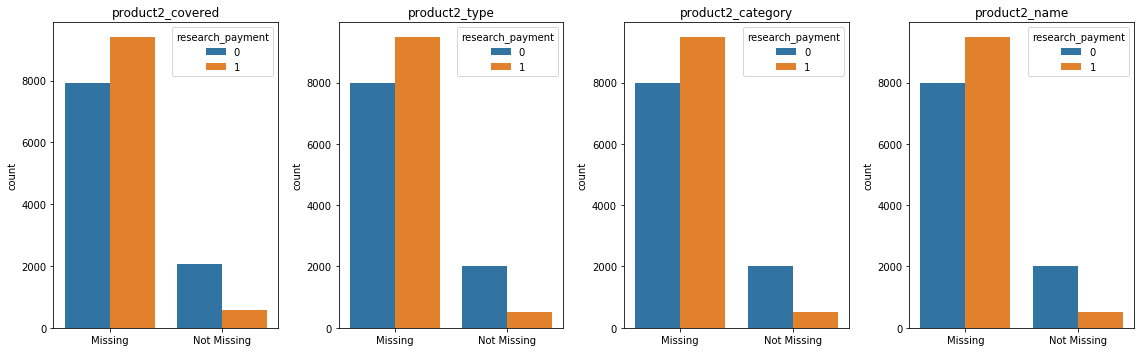

In [71]:
p2_vars = ['product2_covered', 'product2_type', 'product2_category', 'product2_name']
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

for i in range(len(p2_vars)):
    sns.countplot(np.where(df[p2_vars[i]].isnull(), 0, 1), hue=df['research_payment'], ax=ax[i])
    ax[i].set_title(p2_vars[i])
    ax[i].set_xticklabels(['Missing', 'Not Missing'])
    
plt.tight_layout()
plt.show()

In [72]:
df['p2_missing'] = np.where(df.product2_covered.isnull(), 1, 0)
df_test['p2_missing'] = np.where(df_test.product2_covered.isnull(), 1, 0)

df.drop(p2_vars, axis=1, inplace=True)
df_test.drop(p2_vars, axis=1, inplace=True)

**Payment Date**

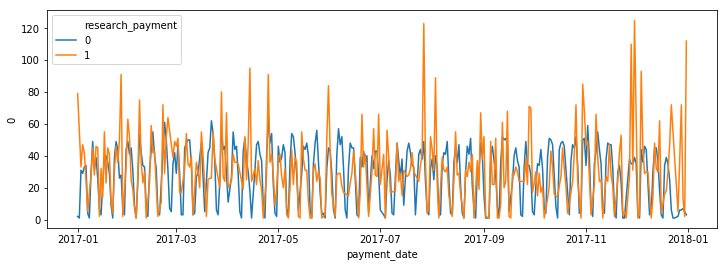

In [109]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
sns.lineplot(x='payment_date', y=0, hue='research_payment', data=df.groupby(['research_payment', 'payment_date']).size().reset_index())
plt.show()

To get as much information as possible from the payment date variable, we can extract the month, year, day of the month and weekday. But some of these are ordered and better expressed as cyclical features. For instance, if we were to represent the months from 1-12, the  distance from 12 to 1 should be the same as 1 to 2. 

In [ ]:
df['']

In [73]:
df.head(2)

,Change_Type,hospital,address,city,state,paying_GPO_state,payment_date,product1_covered,product1_type,product1_category,research_payment,doctor,different_GPO,log_payment_amount,cash_payment,related_prod,p2_missing
0,unchanged,0,other,other,ca,nj,2017-03-14,non-covered,drug,other,1,0,1,5.857933,1,1,1
1,unchanged,0,other,other,oh,ct,2017-07-18,covered,drug,respiratory,0,1,0,1.465568,0,1,1


## Task 4: Modeling

Before setting up the models and tuning, we need to create our pipeline. 

In [91]:
# check for missing data
for c in df.columns.values:
    if df[df[c].isnull()].shape[0] > 0:
        print(c)

In [93]:
# get X and y
y = df.research_payment.values
X = df.drop('research_payment', axis=1).values

y_test = df_test.research_payment.values
X_test = df_test.drop('research_payment', axis=1).values

We have three column transformers:
- One for your categorical variables that need to be one hot encoded.
- One for the categorical variables that need to be mean encoded.
- And one for our one and only continuous variable.